In [1]:
import sys
sys.path.append('/home/users/kokron/Libraries/lim/')
sys.path.append('/home/users/kokron/Projects/preLIMinary/')
from LIM_lightcone import paint_lightcone,make_survey,make_measurements
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp2d,interp1d
from scipy.optimize import curve_fit
import math
from lim import lim

from nbodykit.algorithms import FFTPower

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection

colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['figure.facecolor']='white'
%matplotlib inline

In [2]:
def linear_color(col1,col2):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

#############################################

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

# Setting parameters

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys,z,Dz,sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              Omega_field = 100,dnu=10):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    nuObs, Dnu = Dnu_from_Dz(nu, z, Dz)
    model_params = dict(nu=nu, nuObs=nuObs, 
                        sigma_scatter=sigma_scatter,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':sig_SFR},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=False, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10000, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=dnu*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=Nfeeds, 
                      beam_FWHM=beam*u.arcmin, 
                      tobs=tobs*u.hr,
                      Omega_field=Omega_field*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys,
              zmin_obs, zmax_obs,zmin=2.2,zmax=3.5,
              sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              alpha = 1.37, beta = -1.74,
              dnu=10,
              RAObs_edge = 4.5, DECObs_edge = 4.5,smooth=False):
    nu_CO=115.271*u.GHz

    model_params=dict(halo_lightcone_dir='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':alpha,'beta':beta,'delta_mf':1,'sigma_L':sigma_scatter})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.01*u.Mpc**-1)
    obs_params=dict(zmin = zmin, zmax = zmax,
                    RAObs_min=-RAObs_edge*u.deg,RAObs_max=RAObs_edge*u.deg,
                    DECObs_min=-DECObs_edge*u.deg,DECObs_max=DECObs_edge*u.deg,
                    RA_min=-5.0*u.deg,RA_max=5.0*u.deg,
                    DEC_min=-5.0*u.deg,DEC_max=5.0*u.deg,
                    nuObs_max=nu_CO/(1+zmin_obs), nuObs_min=nu_CO/(1+zmax_obs),
                    beam_FWHM=beam*u.arcmin, 
                    dnu=dnu*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=Nfeeds, 
                    tobs=tobs*u.hr,
                    linear_VID_bin=False, Tmin_VID =-0.5*u.uK,Nbin_hist=50,Tmax_VID=100*u.uK,
                    do_smooth=False,remove_noise=True)
    obs_params.update(model_params)
    return obs_params

# Call lim and LC

We call lim for theoretical comparison, and 3 instance of LC to compare the SFR from UM (its own scatter, SFR running with z), parametric SFR representing UM, and parametric SFR representing BWC13 

#### Custom SFRs

\begin{equation}
\text{SFR}(M) = M_0 \left(\frac{M}{M_a}\right)^a\left[1+ \left(\frac{M}{M_b}\right)^b\right]^c
\end{equation}



In [4]:
def func(M,Ma,Mb,a,b,c):
    M0 = -6
    return np.log10(10**M0*((M/10**Ma)**a)*(1+(M/10**Mb)**b)**c)

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

# def func_dongwoo(M, ):

In [5]:
z = 2.8
logM=np.log10(np.logspace(10, 14, 100))
sfr_um = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_Behroozi.dat')          
popt_um, pcov = curve_fit(func, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[8,12.3,1.9,3,-1.4])
popt_bwc, pcov = curve_fit(func, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[8,12.3,1.9,3,-0.7])

print('Universe Machine SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_um[0],popt_um[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_um[2],popt_um[3],popt_um[4]))
print('')
print('BWC13 SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_bwc[0],popt_bwc[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_bwc[2],popt_bwc[3],popt_bwc[4]))
print('')



Universe Machine SFR at z =  2.8
-------------------------------
M0 = -6.00, Ma = 8.09, Mb = 12.46
a = 1.87, b = 4.65, c = -0.89

BWC13 SFR at z =  2.8
-------------------------------
M0 = -6.00, Ma = 8.20, Mb = 12.32
a = 1.96, b = 6.53, c = -0.32



/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


The cell below implements the calculation of the $\Delta \chi^2$ for varying degrees of the full slope. 

Note that we aren't binning $P(k)$ at all and are currently using all values of $k$ which is wildly unrealistic.

# Swap over to Dongwoo's parametrization


$$ SFR(M) = \frac{C}{(m/M_h)^A + (m/M_h)^B                    }$$

In [6]:
def sfr_dc(m, A, B, C, M_h):
    '''
    Parametrization for SFR(M) based off of 2111.05931 parametrization.
    Equation is: 
    
    SFR(M) = C / ((M/M_h)**A + (M/M_h)**B)
    
    so
    A = low-M slope
    B = high-M slope
    C = amplitude at tilt scale
    M_h = tilt mass
    
    
    Note original use is for L_CO (M_h) but here we'll 
    choose SFR(M_h) instead. Should be equivalent but double check.
    '''
    ratio = m/10**M_h
    
    return np.log10(C/(ratio**A + ratio**B))

def del_A(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    numerator = -C* (ratio)**A *np.log(ratio)
    denom = ((ratio)**A + (ratio)**B)**2 
    
    return np.log10(numerator/denom)

def del_B(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    numerator = -C *(ratio)**B *np.log(ratio)
    denom = ((ratio)**A + (ratio)**B)**2 
    
    return np.log10(numerator/denom)

 
def del_C(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    return np.log10(1/(ratio**A + ratio**B))

def del_M(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    numerator = -(C*(-A*ratio*(ratio)**(-1 + A)* np.log(10) -B*ratio* (ratio)**(-1 + B) * np.log(10)))
    
    denom = (ratio**A + ratio**B)**2
    
    return np.log10(numerator/denom)

popt_um, pcov = curve_fit(sfr_dc, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[3,-1.4,10,12.5])
popt_bwc, pcov = curve_fit(sfr_dc, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[3,-1.4,10,12.5])

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10


2.276856204323389 -1.8836168834940592
0.32681297960924416 -1.99187743311912


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


(-2, 3)

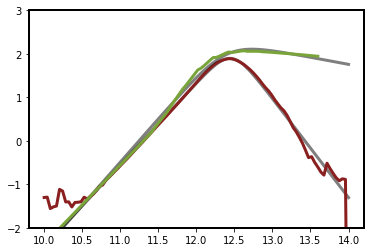

In [7]:
A, B, C, M_h = popt_um
plt.plot(logM,sfr_dc(10**logM, A, B, C, M_h), color='k', alpha=0.5)
plt.plot(logM, np.log10(sfr_um))
print(A, B)
A, B, C, M_h = popt_bwc
print(A, B)
plt.plot(logM, sfr_dc(10**logM, A, B, C, M_h), color='k', alpha=0.5)
# 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3
plt.plot(logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3])


plt.ylim(-2, 3)

0.32
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_152.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_153.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_154.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_155.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_156.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_157.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_158.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_159.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_160.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_161.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_162

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less


-90.99266 91.06757
Note: redshifts have been re-sorted (earliest first)


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:701: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:702: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


{'A': 0.32, 'B': -1.99187743311912, 'C': 192.2219204298769, 'M_h': 2468226254578.985}
104.53089570999146
2.18


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less


-90.98247 82.47685
{'A': 2.18, 'B': -1.99187743311912, 'C': 192.2219204298769, 'M_h': 2468226254578.985}
162.6864402294159


Text(0, 0.5, '$\\log {\\rm SFR}$')

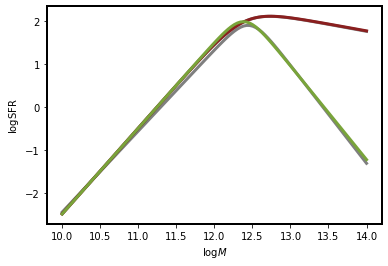

In [20]:
import time
# Plot varying "b+c" for our relation
poptvec = [popt_bwc, popt_um]



Tsys = 10
zmin_obs, zmax_obs = 2.6,3.0
sigma_scatter=0.3
sig_SFR=0.5
# M = lim(lim_params('../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat',
#                    Tsys,z,Dz,sigma_scatter=sigma_scatter,sig_SFR = sig_SFR,Omega_field=81))



st = time.time()


monovec = []

vidvec = []

chi2vec = []

chi2vec_pk = []
chi2vec_vid = []


kmax = 1.0

for i in range(2):
    
    A, B, C, M_h = poptvec[i]
    
    plt.plot(logM,sfr_dc(10**logM, A, B, C, M_h), color='k', alpha=0.5)

A, B, C, M_h = popt_bwc

model_first = dict(A=A, B=B, C=C, M_h=10**M_h)

CO = make_measurements(LC_params(True, 'Dongwoo_SFR', model_first, Tsys,zmin_obs,zmax_obs, beam=4.5))

N_c = 2

#-6, 6 sigma for temperature bins.
Tbin_edges = CO.sigmaN*(CO.supersample**1.5)*6
kstar = 0.1
# print('Here?')
Nbin_hist = 25

for i, A in enumerate(np.linspace(0.32, 2.18, N_c)):
    
    
    model_vary = dict(A=A, B=B, C=C, M_h=10**M_h)
    print(A)
    CO.update(seed=0,
              SFR_pars = LC_params(True, 'Dongwoo_SFR', model_vary, Tsys,zmin_obs,zmax_obs)['SFR_pars'],
              do_smooth=True,
              Nbin_hist = Nbin_hist
            )
    
    CO.Pk_2d
    kmask = CO.k_Pk_poles.value < kmax
    vidvec.append([CO.Ti, CO.Bi_VID])


    print(np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))
    # Make the joint covariance matrix:
    # Some VID entries have 0 values. Take only the non-zero
    if i==0:
        vid_mask = CO.Bi_VID > 0


    #Check the Nmodes calculation here, might be off or something...
        
        cov = np.diag(np.hstack([CO.covmat_00.value[kmask], CO.Bi_VID_covariance.diagonal()[vid_mask]]))
        
#         knorm = np.where()
    #Make data vectors
        pkfid = CO.Pk_0.value[kmask]
        vidfid = CO.Bi_VID[vid_mask]
        dv_0 = np.hstack([pkfid, vidfid])
        
        norm_idx = find_nearest(CO.k_Pk_poles.value[kmask], kstar)
        
        norm_amp = pkfid[norm_idx]
        


    #Full chi2
    norm_test = CO.Pk_0.value[kmask][norm_idx]
    pkadd = CO.Pk_0.value[kmask] * norm_amp / norm_test
    monovec.append(pkadd)
    
    
    lc_dv = np.hstack([pkadd, CO.Bi_VID[vid_mask]])
    res = (lc_dv - dv_0)**2
    chi2 = np.sum(res/cov.diagonal())
    chi2vec.append(chi2)
    
    #Pk chi2
    res = (pkfid - pkadd)**2
    chi2_pk = np.sum(res/cov.diagonal()[:len(pkfid)])
    chi2vec_pk.append(chi2_pk)
    
    #VID chi2
    res = (vidfid - CO.Bi_VID[vid_mask])**2
    chi2_vid = np.sum(res/cov.diagonal()[len(pkfid):])
    chi2vec_vid.append(chi2_vid)
    plt.plot(logM, sfr_dc(10**logM, A, B, C, M_h))
    print(model_vary)
    print(time.time() - st)
plt.xlabel(r'$\log M$')
plt.ylabel(r'$\log {\rm SFR}$')

In [21]:
CO.Bi_VID.shape

(50,)

Text(0.5, 1.0, '$T_{\\rm sys}=10.00$K')

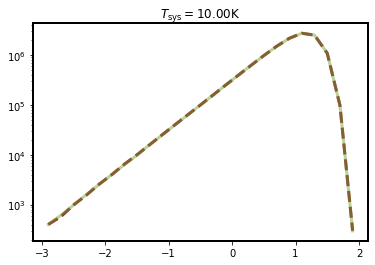

In [22]:

plt.plot(CO.Ti, CO.Bi_VID[:Nbin_hist], ls='--', color='C0')
plt.plot(CO.Ti, CO.Bi_VID[Nbin_hist:], color='C1', alpha=0.5)
plt.yscale('log')
plt.title(r'$T_{\rm sys}=%.2f$K'%Tsys)

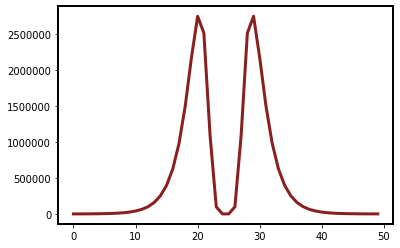

In [23]:
plt.plot(np.hstack([CO.Bi_VID[:Nbin_hist], CO.Bi_VID[Nbin_hist:][::-1]]))

# Fisher time

Instead of varying the high mass slope, let's do Fisher forecasts of parameter constraints for our survey assuming two fiducial values, one for BWC and one for UM. 

Hopefully the constraints don't change much!

In [204]:
nparams = len(poptvec[0])

derivvec = np.zeros(shape=(3, nparams))

###Observational params
Tsys = 0
# zmin_obs, zmax_obs = 2.4,3.4

zmin_obs, zmax_obs = 2.6,2.8

sigma_scatter=0.3
####

st = time.time()

###Make first map to set the seed
A, B, C, M_h = popt_bwc

model_first = dict(A=A, B=B, C=C, M_h=10**M_h)

CO = make_measurements(LC_params(True, 'Dongwoo_SFR', model_first, Tsys,zmin_obs,zmax_obs, beam=4.5))



Tbin_edges = CO.sigmaN*(CO.supersample**1.5)*6

lower_end = np.min([-Tbin_edges.value, -0.5])*u.uK
higher_end = np.max([Tbin_edges.value, 100])*u.uK

Nbin_hist = 25

kstar = 0.1
####
stepvec = np.array([0.01, 0.01, 0.01, 0.005])
stepvec = np.array([0.01, 0.01, 0.01, 0.01])
for n in range(1):
    fiducial = poptvec[n]

    derivvec[1] = fiducial
    
    derivvec[0] = fiducial*(1-stepvec)
    derivvec[-1] = fiducial*(1+stepvec)
    
    deltavec = 0.5*(derivvec[-1] - derivvec[0])
    
    steparr = [-1, 0]
    
    
    monovec = []

    vidvec = []

    chi2vec = []

    chi2vec_pk = []
    chi2vec_vid = []

    
    #Compute covariance
    A, B, C, M_h = derivvec[1]

    model_vary = dict(A=A, B=B, C=C, M_h=10**M_h)

    CO.update(seed=0,
              SFR_pars = LC_params(True, 'Dongwoo_SFR', model_vary, Tsys,zmin_obs,zmax_obs)['SFR_pars'],
              do_smooth=True,
              Tmin_VID = -0.5*u.uK,
              Tmax_VID = 100*u.uK,
              Nbin_hist = Nbin_hist,
              linear_VID_bin=True)

    CO.Pk_2d
    kmask = CO.k_Pk_poles.value < kmax
    vidvec.append([CO.Ti, CO.Bi_VID])


        
    vid_mask = CO.Bi_VID == 0


    #Check the Nmodes calculation here, might be off or something...
    vid_diag = 1.*CO.Bi_VID_covariance.diagonal()
    vid_diag[vid_mask] = 1

    cov = np.diag(np.hstack([CO.covmat_00.value[kmask], vid_diag]))

    pkfid = CO.Pk_0.value[kmask]
    vidfid = CO.Bi_VID
    true_fid = np.hstack([pkfid, vidfid])

    derivvar = np.zeros(shape=(4, len(true_fid)))
    print('Fiducial: ', np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))

    print('          A        B            C             M_h')

    for param in range(4):
     
        fid_params = derivvec[1]
        
        param_deriv = np.zeros(shape=(2, len(true_fid)))
        
        for i, step in enumerate(steparr):
            mod_params = 1.*fid_params
            
            mod_params[param] = derivvec[step, param]
            
            A, B, C, M_h = mod_params
            print(mod_params)
            model_vary = dict(A=A, B=B, C=C, M_h=10**M_h)

            CO.update(seed=0,
                      SFR_pars = LC_params(True, 'Dongwoo_SFR', model_vary, Tsys,zmin_obs,zmax_obs)['SFR_pars'],
                      do_smooth=True,
                      Tmin_VID = -0.5*u.uK,
                      Tmax_VID = 100*u.uK,
                      Nbin_hist = Nbin_hist,
                      linear_VID_bin=True)
            
            print(np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))

            CO.Pk_2d
            kmask = CO.k_Pk_poles.value < kmax
#             vidvec.append([CO.Ti, CO.Bi_VID])

            pkfid = CO.Pk_0.value[kmask]
    
            vidfid = CO.Bi_VID

            dv_fid = np.hstack([pkfid, vidfid])

            param_deriv[i] = dv_fid
            chi2vec.append(dv_fid)
        deriv = (param_deriv[0] - param_deriv[1])/(2*deltavec[param])
        derivvar[param] = deriv
print(time.time() - st)

/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_152.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_153.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_154.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_155.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_156.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_157.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_158.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_159.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_160.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_161.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_162.fits

In [205]:
print(np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))
print(np.mean(CO.obs_3d_map))

-0.8229262 51.445293
1.1453921e-09


In [206]:
# print('          A        B            C             M_h')
# print(mod_params)

In [207]:
bins = np.linspace(-100, 100, 25)

bins2 = np.linspace(-100, 100, 50)

In [208]:
hist1 = np.histogram(CO.obs_3d_map.value.flatten(), bins=bins)

hist2 = np.histogram(CO.obs_3d_map.value.flatten(), bins=bins2)

In [209]:
np.sum(hist1[0]) - np.sum(hist2[0])

0

Text(0.5, 0, '$\\log T\\, [\\mu {\\rm K}]$')

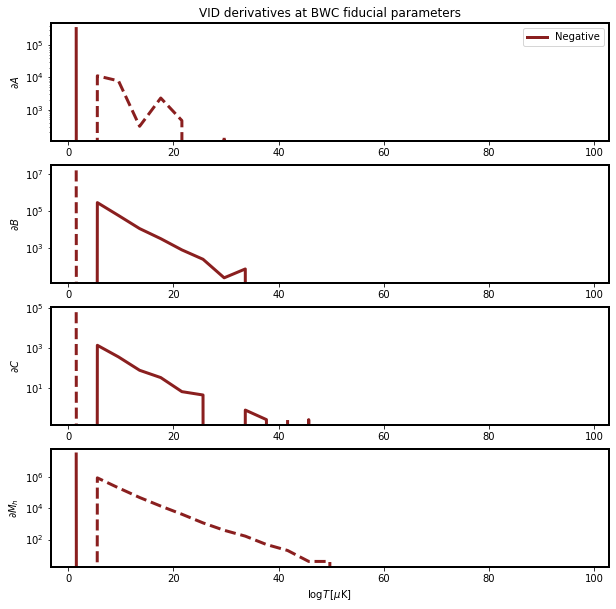

In [210]:
paramlabels = ['A', 'B', 'C', 'M_h']

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10), facecolor='w')
for i in range(4):
    plus = chi2vec[2*i]
    minus = chi2vec[2*i+1]
    
    twopt = (plus - minus)/(2*deltavec[i])
    
#     threept = (plus + minus - 2*true_fid)/(deltavec[i]**2)
    ax[i].plot(CO.Ti, twopt[68:68+Nbin_hist], color='C0', label='Negative')
    ax[i].plot(CO.Ti, -twopt[68:68+Nbin_hist], ls='--',color='C0')  
    
#     ax[i].plot(CO.Ti, twopt[68+Nbin_hist:], color='C1', label='Positive')
#     ax[i].plot(CO.Ti, -twopt[68+Nbin_hist:], ls='--',color='C1')  
#     ax[i].plot(CO.Ti, twopt[68:]/true_fid[68:], color='C0', label='Light cone')
#     ax[i].plot(CO.Ti, -twopt[68:]/true_fid[68:], ls='--',color='C0')

#     print(i)
#     ax[i].loglog(deriv_bwc[0], deriv_bwc[i+1], color='C1', label='Analytic')
#     if i==3:
        
#         ax[i].loglog(deriv_bwc[0],  -(10**12.39/0.4342944819032518) *deriv_bwc[i+1], color='C1', ls='--')
#     else:
#         ax[i].loglog(deriv_bwc[0],  -deriv_bwc[i+1], color='C1', ls='--')

#     ax[i].plot(threept/true_fid, label='3pt')
#     ax[i].vlines(68, -10, 10, color='k', alpha=0.1)
    ax[i].set_ylabel(r'$\partial %s$'%paramlabels[i])

    ax[i].set_yscale('log')
#     ax[i].set_ylim(-1, 1)
#     ax[i].set_ylim(1e-1, 1e5)
ax[0].legend()
ax[0].set_title('VID derivatives at BWC fiducial parameters')
ax[3].set_xlabel(r'$\log T\, [\mu {\rm K}]$')

Now get covariance and build "Fisher"

In [211]:
derivvar.shape

(4, 93)

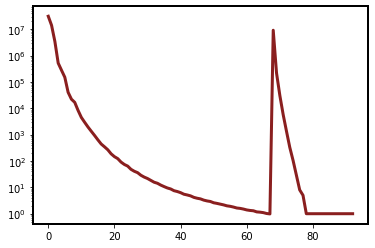

In [212]:
plt.yscale('log')
plt.plot(cov.diagonal())

In [213]:

invcov = np.linalg.inv(cov)




fisher = np.einsum('ik, kp, pj->ij', derivvar, invcov, derivvar.T)


cov_pk = cov[:68,:68]

inv_pk = np.linalg.inv(cov_pk)


fisher_pk = np.einsum('ik, kp, pj->ij', derivvar[:,:68], inv_pk, derivvar[:,:68].T)


n1 = 0
n2 = Nbin_hist

cov_vid = cov[68+n1:68+n2, 68+n1:68+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid = np.einsum('ik, kp, pj->ij', derivvar[:,68+n1:68+n2], inv_vid, derivvar[:,68+n1:68+n2].T)



In [214]:
# np.sqrt(param_all.diagonal())

array([0.00965336, 0.00116553, 1.09447434, 0.00189138])


In [215]:
# np.sqrt(param_vid.diagonal())

# Plot contours

In [216]:
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
from getdist.gaussian_mixtures import GaussianND
plt.rcParams['text.usetex']=False
paramlabels = ['A', 'B', 'C', 'M_h']

# names = ['s8', 'Om', 'b1', 'b2', 'bs2', 'bk2']
# labels =  [r'$\sigma_8$', r'$\Omega_m$', r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$b_{\nabla^2}$']


param_all = np.linalg.inv(fisher)


param_pk = np.linalg.inv(fisher_pk)

param_vid = np.linalg.inv(fisher_vid)


print('All: ', np.sqrt(param_all.diagonal()))
print('VID: ', np.sqrt(param_vid.diagonal()))


gauss_all= GaussianND(fiducial, param_all,labels=paramlabels,label = r'$P(k) + {\rm VID}$')

gauss_pk = GaussianND(fiducial, param_pk, labels=paramlabels, label=r'$P(k) \,{\rm only}$')

gauss_vid = GaussianND(fiducial, param_vid, labels=paramlabels, label=r'${\rm VID\, only}$')
# fiducial = 

All:  [0.01694445 0.00426682 1.64591957 0.0017991 ]
VID:  [0.01698569 0.00429921 1.66318259 0.00185812]


In [116]:
# All:  [0.00646484 0.00791738 0.73328591 0.00341959]
# VID:  [0.00839621 0.01192418 1.73563184 0.02114551]

Linear Nbin_hist = 25 T = 0:
All:  [0.01694445 0.00426682 1.64591957 0.0017991 ]
VID:  [0.01698569 0.00429921 1.66318259 0.00185812]

Linear Nbin_hist = 50 T = 0:
All:  [0.00626914 0.00291143 0.94846456 0.00112233]
VID:  [0.00627525 0.0029784  0.95135268 0.00115217]

Linear Nbin_hist = 25 T=10:
All:  [ 0.13213646  0.1020348  14.56673807  0.02527387]
VID:  [ 0.136549    0.16008204 19.81501313  0.03104585]


Linear Nbin_hist = 50 T=10: 
All:  [0.07651754 0.06055929 7.93551341 0.01329905]
VID:  [0.07670666 0.06852532 8.75134385 0.01880744]

SyntaxError: invalid syntax (<ipython-input-116-a43a954654aa>, line 4)

In [179]:
0.13213646/0.07651754

1.7268780465237124

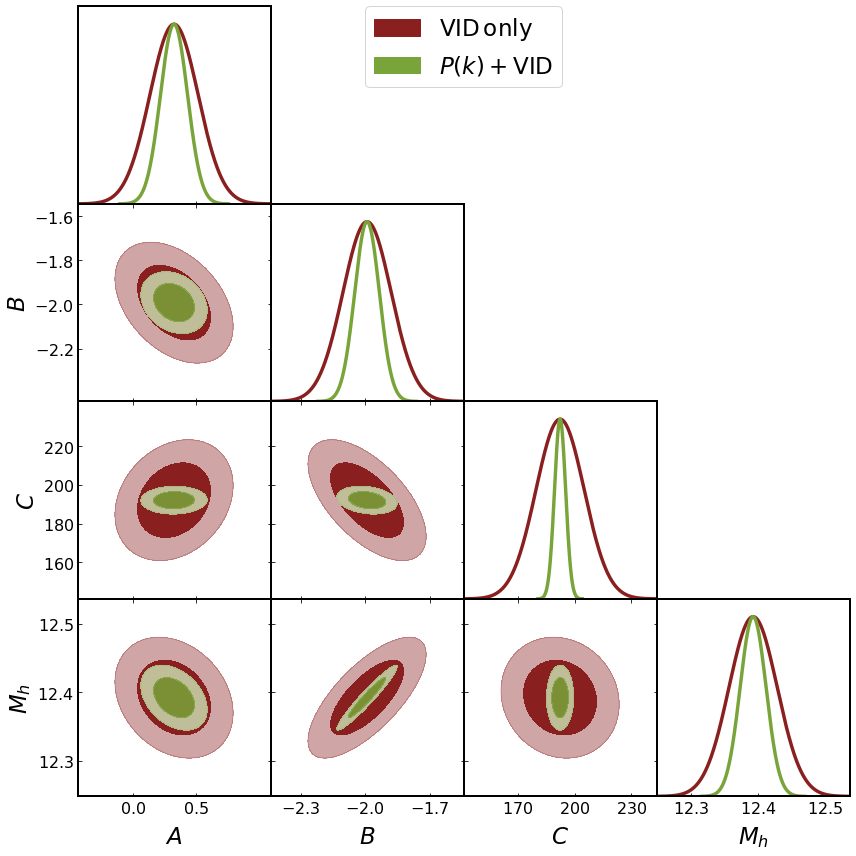

In [115]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.linewidth=4
g.settings.axes_labelsize=24
g.settings.axes_fontsize=17
g.settings.legend_fontsize=24
g.triangle_plot([gauss_vid, gauss_all],filled=True,
               line_args=[{'color':'C0'}, {'color':'C1'}], 
    contour_colors=['C0', 'C1'])

# Weird negative vs positive information content

In [39]:

invcov = np.linalg.inv(cov)




fisher = np.einsum('ik, kp, pj->ij', derivvar, invcov, derivvar.T)


cov_pk = cov[:68,:68]

inv_pk = np.linalg.inv(cov_pk)


fisher_pk = np.einsum('ik, kp, pj->ij', derivvar[:,:68], inv_pk, derivvar[:,:68].T)


n1 = 0
n2 = Nbin_hist

cov_vid = cov[68+n1:68+n2, 68+n1:68+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid = np.einsum('ik, kp, pj->ij', derivvar[:,68+n1:68+n2], inv_vid, derivvar[:,68+n1:68+n2].T)


n1 = Nbin_hist
n2 = 2*Nbin_hist


cov_vid = cov[68+n1:68+n2, 68+n1:68+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid2 = np.einsum('ik, kp, pj->ij', derivvar[:,68+n1:68+n2], inv_vid, derivvar[:,68+n1:68+n2].T)


n1 = 0
n2 = 2*Nbin_hist

cov_vid = cov[68+n1:68+n2, 68+n1:68+n2]

inv_vid = np.linalg.inv(cov_vid)
fisher_vid3 = np.einsum('ik, kp, pj->ij', derivvar[:,68+n1:68+n2], inv_vid, derivvar[:,68+n1:68+n2].T)


param_vid = np.linalg.inv(fisher_vid)
param_vid2 = np.linalg.inv(fisher_vid2)
param_vid3 = np.linalg.inv(fisher_vid3)

gauss_vid = GaussianND(fiducial, param_vid, labels=paramlabels, label=r'Negative T only')
gauss_vid2 = GaussianND(fiducial, param_vid2, labels=paramlabels, label=r'Positive T only')
gauss_vid3 = GaussianND(fiducial, param_vid3, labels=paramlabels, label=r'All T')


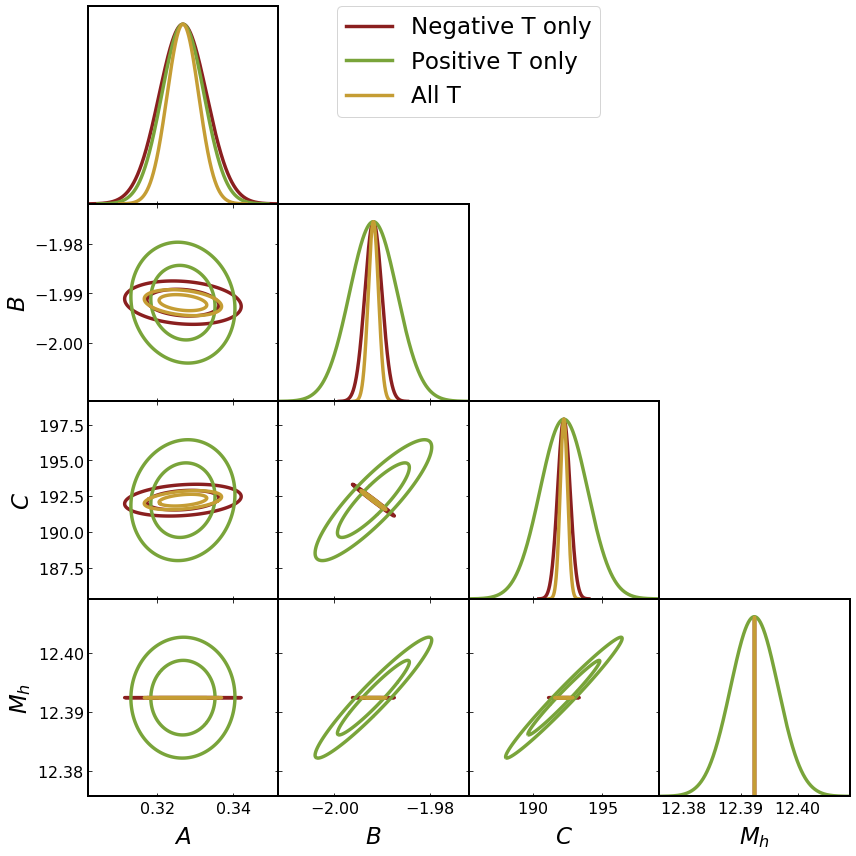

In [40]:
g = plots.get_subplot_plotter(width_inch=12)
g.settings.linewidth=4
g.settings.axes_labelsize=24
g.settings.axes_fontsize=17
g.settings.legend_fontsize=24
g.triangle_plot([gauss_vid, gauss_vid2,gauss_vid3],filled=False,
               line_args=[{'color':'C0'}, {'color':'C1'},{'color':'C2'}], 
    contour_colors=['C0', 'C1', 'C2'])

In [43]:
print(np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))

-0.7979096 96.74185


In [42]:

np.sum(CO.obs_3d_map < 0)/np.sum(CO.obs_3d_map > 0)

2.708850017539574

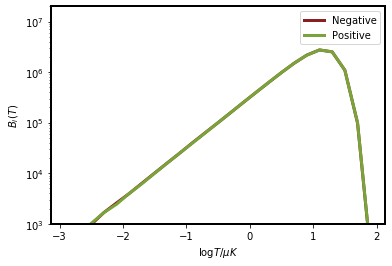

In [68]:
plt.plot(CO.Ti, true_fid[68:68+Nbin_hist],label='Negative')
plt.plot(CO.Ti, true_fid[68+Nbin_hist:68+2*Nbin_hist], label='Positive')
plt.ylabel(r'$B_i (T)$')
plt.xlabel(r'$\log T/\mu K$')
# plt.plot(true_fid[68:])

plt.yscale('log')
# plt.vlines(25, 0, 2e7)
plt.ylim(1e3, 2e7)
plt.legend()

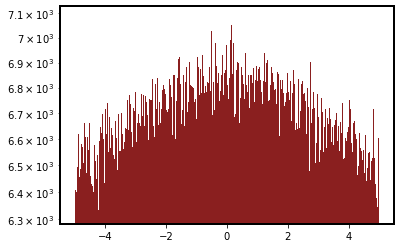

In [101]:
bins = np.linspace(-5, 5, 1000)
plt.hist(CO.obs_3d_map.value.flatten(), bins=bins)
plt.yscale('log')